In [ ]:
""""
# Some of the Required packages
!pip install pystac_client
# !pip install --upgrade dask
!pip install odc-stac
!pip install xarray-spatial
# !pip install dask[dataframe]
!pip install folium matplotlib mapclassify
!pip install geojson
!pip install odc-algo
!pip install odc-ui
""""

In [1]:
from pystac_client import Client
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import pystac_client
import dask.distributed
import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
import yaml
from branca.element import Figure
from IPython.display import HTML, display
import odc.ui
from odc.stac import stac_load
from geojson.utils import coords
from shapely.geometry import LineString
from shapely.geometry import shape
from geojson.utils import coords
from shapely.geometry import LineString
from shapely.geometry import shape

In [2]:
def get_bbox(geometry):
    return LineString(coords(geometry)).bounds

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

def get_search_json(datatime, bbox, filters=None, url_l="https://earth-search.aws.element84.com/v1",
                    collections=["sentinel-2-l2a"]):
  catalog = Client.open(url_l)
  query = catalog.search(
      collections=collections, datetime=datatime, limit=100,
      query=filters,
      bbox=bbox,
      # sortby=[
      #   {
      #       "field": "properties.datatime",
      #       "direction": "asc"
      #   },]
  )
  items = list(query.items())
  print(f"Found: {len(items):d} datasets")
  # Convert STAC items into a GeoJSON FeatureCollection
  stac_json = query.item_collection_as_dict()
  return stac_json, items

def get_gdf(stac_json):
  gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

  # Compute granule id from components
  gdf["granule"] = (
      gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
      + gdf["mgrs:latitude_band"]
      + gdf["mgrs:grid_square"]
  )
  return gdf

def plot_bounds(gdf):
  fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
  )
  _ = fig.set_title("STAC Query Results")


def plot_bounds_map(gdf, bbox, name_g="STAC", tooltip=[
          "granule",
          "datetime",
          "s2:nodata_pixel_percentage",
          "eo:cloud_cover",
          "s2:vegetation_percentage",
          "s2:water_percentage",  
      ]):
  fig = Figure(width="400px", height="500px")
  map1 = folium.Map()
  fig.add_child(map1)

  folium.GeoJson(
      shapely.geometry.box(*bbox),
      style_function=lambda x: dict(fill=False, weight=2, opacity=0.7, color="olive"),
      name="Query",
      tooltip="Query",
  ).add_to(map1)

  gdf.explore(
      "granule",
      categorical=True,
      tooltip=tooltip,
      popup=True,
      style_kwds=dict(fillOpacity=0.1, width=2),
      name=name_g,
      m=map1,
  )

  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
  display(fig)

In [3]:
# https://geojson.io/#map=8.06/49.835/6.061

france_bbox = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              2.6360361275716855,
              48.072322144360385
            ],
            [
              2.6360361275716855,
              46.11030922163221
            ],
            [
              5.960779085519363,
              46.11030922163221
            ],
            [
              5.960779085519363,
              48.072322144360385
            ],
            [
              2.6360361275716855,
              48.072322144360385
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

Found: 2 datasets


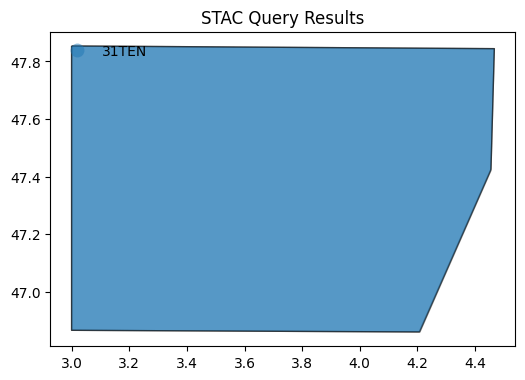

In [4]:
datatime = "2023-02-01/2023-04-30" 
filters = {
    "eo:cloud_cover":{"lt":0.6}, 
    # s2:nodata_pixel_percentage
    "mgrs:grid_square": {"eq": "EN"}
}
bbox = get_bbox(france_bbox)
stac_json, items = get_search_json(datatime, bbox, filters)
if items:
    gdf = get_gdf(stac_json)
    plot_bounds(gdf)
    plot_bounds_map(gdf, bbox)

In [6]:
items

[<Item id=S2B_31TEN_20230301_0_L2A>, <Item id=S2A_31TEN_20230214_0_L2A>]

In [7]:
tidx = 0 # only one timestamp / acquisition

In [8]:
items[tidx]

<Item id=S2B_31TEN_20230301_0_L2A>

In [9]:
items[tidx].id

'S2B_31TEN_20230301_0_L2A'

In [10]:
bands=["blue", "green", "red", "nir", "scl"] # ["B02", "B03", "B04", "B08", "SCL"]
# downloading the tile specified bands
ds = odc.stac.stac_load([items[tidx]], bands=bands, chunks={}, resolution=10)

In [11]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 88kB 5.3e+06 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 8B 2023-03-01T10:57:53.595000
Data variables:
    blue         (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    green        (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    red          (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    nir          (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    scl          (time, y, x) uint8 121MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>

In [12]:
ds = ds.rename_vars({"blue": "B2", "green": "B3", "red": "B4", "nir": "B8"})

In [13]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 88kB 5.3e+06 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 8B 2023-03-01T10:57:53.595000
Data variables:
    B2           (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    B3           (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    B4           (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    B8           (time, y, x) uint16 241MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    scl          (time, y, x) uint8 121MB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>

In [19]:
# saving the tile, takes some time
ds.to_netcdf(f"{items[tidx].id}.nc")